In [16]:
!pip install --upgrade numpy scipy

  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/64/41/284783f1014685201e447ea976e85fed0e351f5debbaf3ee6d7645521f1d/numpy-1.26.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached numpy-1.26.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.1
    Uninstalling numpy-1.26.1:
      Successfully uninstalled numpy-1.26.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.2 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

/opt/conda/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


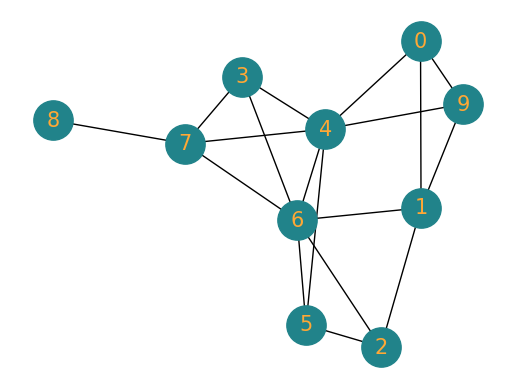

In [18]:
# Create graph
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

# Plot graph
plt.figure()
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_size=800,
                 node_color='#21838A',
                 cmap='#135353',
                 font_size=15,
                 font_color='#FFA835'
                 )

In [19]:
random.seed(0)
np.random.seed(0)

def next_node(previous, current, p, q):
    alphas = []

    # Get the neighboring nodes
    neighbors = list(G.neighbors(current))
    
    # Calculate the appropriate alpha value for each neighbor
    for neighbor in neighbors:
        # Distance = 0: probability to return to the previous node
        if neighbor == previous:
            alpha = 1/p
        # Distance = 1: probability of visiting a local node
        elif G.has_edge(neighbor, previous):
            alpha = 1
        # Distance = 2: probability to explore an unknown node
        else:
            alpha = 1/q
        alphas.append(alpha)

    # Normalize the alpha values to create transition probabilities
    probs = [alpha / sum(alphas) for alpha in alphas]
    
    # Randomly select the new node based on the transition probabilities
    next = np.random.choice(neighbors, size=1, p=probs)[0]
    return next

In [20]:
def random_walk(start, length, p, q):
    walk = [start]
    
    for i in range(length):
        current = walk[-1]
        previous = walk[-2] if len(walk) > 1 else None
        next = next_node(previous, current, p, q)
        walk.append(next)
    
    return walk

In [21]:
random_walk(0, 8, p=1, q=1)

[0, 4, 7, 6, 4, 5, 4, 5, 6]

In [22]:
random_walk(0, 8, p=1, q=10)

[0, 9, 1, 9, 1, 9, 1, 0, 1]

In [23]:
random_walk(0, 8, p=10, q=1)

[0, 1, 9, 4, 7, 8, 7, 4, 6]

In [24]:
# Load dataset
G = nx.karate_club_graph()

# Process labels (Mr. Hi = 0, Officer = 1)
labels = []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

# Create a list of random walks
walks = []
for node in G.nodes:
    for _ in range(80):
        walks.append(random_walk(node, 10, 3, 2))

# Create and train Word2Vec for DeepWalk
node2vec = Word2Vec(walks,
                hs=1,   # Hierarchical softmax
                sg=1,   # Skip-gram
                vector_size=100,
                window=10,
                workers=2,
                min_count=1,
                seed=0)
node2vec.train(walks, total_examples=node2vec.corpus_count, epochs=30, report_delay=1)

# Create masks to train and test the model
train_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
test_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]
labels = np.array(labels)

# Train Node2Vec classifier
clf = RandomForestClassifier(random_state=0)
clf.fit(node2vec.wv[train_mask], labels[train_mask])

# Evaluate accuracy
y_pred = clf.predict(node2vec.wv[test_mask])
acc = accuracy_score(y_pred, labels[test_mask])
print(f'Node2Vec accuracy = {acc*100:.2f}%')

Node2Vec accuracy = 90.91%
